In [3]:
import os
import uuid
import random
import tensorflow as tf

In [4]:
path="data"

In [5]:
len(os.listdir("data/images"))

0

# labeling the data

In [14]:
!labelme

In [16]:
img_path = os.path.join("data", "images")
images_list=os.listdir(img_path)

In [26]:
images_list=os.listdir(img_path)
random.shuffle(images_list)
for idx,i in enumerate(images_list,1):
    old_path=os.path.join(img_path,i)
    if idx<=len(images_list)*70/100:
        new_path=os.path.join("data","train","images",i)
        os.replace(old_path,new_path)
    elif len(images_list)*70/100<idx<=len(images_list)*70/100+int(len(images_list)*15/100):
        new_path=os.path.join("data","test","images",i)
        os.replace(old_path,new_path)
    else:
        new_path=os.path.join("data","val","images",i)
        os.replace(old_path,new_path)

# Reviewing the dataset

In [6]:
import numpy as np
import tensorflow as tf
import json
import cv2
import matplotlib.pyplot as plt

In [7]:
gpus=tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu,True)
    print(gpu)

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [35]:
for folder in ["train","test","val"]:
    for file in os.listdir(os.path.join('data',folder,'images')):
        filename=file.split(".")[0]+'.json'
        existing_filepath=os.path.join("data","labels",filename)
        if os.path.exists(existing_filepath):
            new_filepath=os.path.join("data",folder,"labels",filename)
            os.replace(existing_filepath,new_filepath)

In [8]:
import albumentations as alb

In [9]:
augmentor=alb.Compose([alb.RandomCrop(width=450,height=450),
                       alb.HorizontalFlip(p=0.5),
                       alb.RandomBrightnessContrast(p=0.2),
                       alb.RandomGamma(p=0.2),
                       alb.RGBShift(p=0.2),
                       alb.VerticalFlip(p=0.5)],
                      bbox_params=alb.BboxParams(format="albumentations",label_fields=['class_labels']))

# checking how to apply the albumentations in images

In [12]:
img=cv2.imread("data/train/images/b8f849a8-c234-11ed-b8f7-80b655531500.jpg")

In [13]:
with open("data/train/labels/b8f849a8-c234-11ed-b8f7-80b655531500.json","r") as f:
    label=json.load(f)

In [14]:
label["shapes"][0]["label"]

'face'

In [15]:
points=label["shapes"][0]["points"]

In [16]:
coords=[0,0,0,0]
coords[0]=points[0][0]
coords[1]=points[0][1]
coords[2]=points[1][0]
coords[3]=points[1][1]

In [17]:
coords=list(np.divide(coords,[640,480,640,480]))

In [18]:
augmented=augmentor(image=img,bboxes=[coords],class_labels=['face'])

In [19]:
augmented["image"].shape

(450, 450, 3)

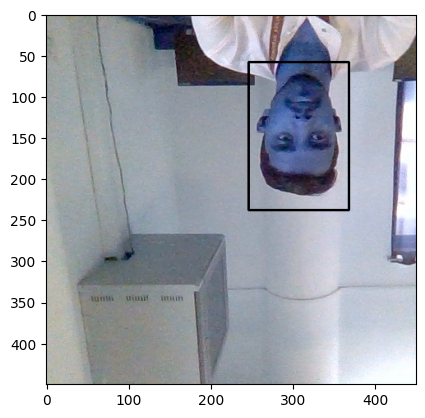

In [20]:
cv2.rectangle(augmented["image"],tuple(np.multiply(augmented['bboxes'][0][:2],[450,450]).astype(int)),tuple(np.multiply(augmented['bboxes'][0][2:],[450,450]).astype(int)),(0,0,0),2)

plt.imshow(augmented["image"])

# Applying albumentation on images

In [23]:
try:
    os.mkdir("aug_data")
    for i in ['val','train','test']:
        os.mkdir(f"aug_data/{i}")
        for j in ["images","labels"]:
            os.mkdir(f"aug_data/{i}/{j}")
except Exception as e:
    print(e)

In [24]:
for partition in ['train','test','val']:
    for image in os.listdir(os.path.join("data",partition,"images")):
        img=cv2.imread(os.path.join("data",partition,"images",image))
        
        coords=[0,0,0.0000001,0.0000001]
        label_path=os.path.join('data',partition,"labels",f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, "r") as f:
                label=json.load(f)
            
            points=label["shapes"][0]["points"]
            coords[0]=points[0][0]
            coords[1]=points[0][1]
            coords[2]=points[1][0]
            coords[3]=points[1][1]
            
            coords=list(np.divide(coords, [640,480,640,480]))
            
        try:
            for x in range(60):
                augmented=augmentor(image=img,bboxes=[coords],class_labels=['face'])
                cv2.imwrite(os.path.join('aug_data',partition,"images",f'{image.split(".")[0]}.{x}.jpg'),augmented["image"])
                
                annotation={}
                annotation["image"]=image
                
                if os.path.exists(label_path):
                    if len(augmented["bboxes"])==0:
                        annotation["bbox"]=[0,0,0,0]
                        annotation["class"]=0
                    else:
                        annotation["bbox"]=augmented["bboxes"][0]
                        annotation['class']=1
                else:
                    annotation["bbox"]=[0,0,0,0]
                    annotation["class"]=0
                
                with open(os.path.join('aug_data',partition,"labels",f'{image.split(".")[0]}.{x}.json'),"w") as f:
                    json.dump(annotation,f)
                    
        except Exception as e:
            raise e
                    

37200